<a href="https://colab.research.google.com/github/letpires/MariaEduardaDeAzevedo/blob/master/vbr_csgr_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
# Defining the google credential as a environement
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="key_vibra.json"

In [81]:
# Carregando bibliotecas
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

In [82]:
#Pegando os dados do BigQuery

import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage

# Explicitly create a credentials object. This allows you to use the same
# credentials for both the BigQuery and BigQuery Storage clients, avoiding
# unnecessary API calls to fetch duplicate authentication tokens.
credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

# Make clients.
bqclient = bigquery.Client(credentials=credentials, project=your_project_id)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

# Download a table.
table = bigquery.TableReference.from_string(
    "vibra-022021.vibraBQ.vbr_ytb_pprz_videos_stats"
)
rows = bqclient.list_rows(
    table,
    selected_fields=[
        bigquery.SchemaField("channel_id", "STRING"),
        bigquery.SchemaField("video_id", "STRING"),
        bigquery.SchemaField("likes", "STRING"),
        bigquery.SchemaField("dislikes", "STRING"),
        bigquery.SchemaField("views", "STRING"),
        bigquery.SchemaField("comments_count", "STRING"),
        bigquery.SchemaField("is_commentable", "STRING"),
        bigquery.SchemaField("updated_at", "TIMESTAMP"),                      
    ],
)
dataframe = rows.to_dataframe()

In [83]:
# Pritando as primeiras linhas
dataframe.head()

,channel_id,video_id,likes,dislikes,views,comments_count,is_commentable,updated_at
0,UCG-fFAxQjZgJmn0w7Brj5xQ,NAtBWIcZh-M,3882,253,236509,49,true,2021-05-03 18:04:26+00:00
1,UCG-fFAxQjZgJmn0w7Brj5xQ,iPm0zeYp0PU,3972,185,231872,52,true,2021-05-03 18:04:26+00:00
2,UCG-fFAxQjZgJmn0w7Brj5xQ,WUOPyq-iAUw,4085,339,242798,75,true,2021-05-03 18:04:26+00:00
3,UCG-fFAxQjZgJmn0w7Brj5xQ,AZOfUROgv3w,4160,229,267444,84,true,2021-05-03 18:04:26+00:00
4,UCG-fFAxQjZgJmn0w7Brj5xQ,kSW0fxmsBrg,6392,130,188539,1110,true,2021-05-03 18:04:26+00:00


In [84]:
#Removendo itens duplicados a partir do video_id, levano em conta o número de views maior
dataframe = dataframe.sort_values('updated_at', ascending=False).drop_duplicates(subset='video_id', keep='first').sort_index()
dataframe

,channel_id,video_id,likes,dislikes,views,comments_count,is_commentable,updated_at
0,UCG-fFAxQjZgJmn0w7Brj5xQ,NAtBWIcZh-M,3882,253,236509,49,true,2021-05-03 18:04:26+00:00
1,UCG-fFAxQjZgJmn0w7Brj5xQ,iPm0zeYp0PU,3972,185,231872,52,true,2021-05-03 18:04:26+00:00
2,UCG-fFAxQjZgJmn0w7Brj5xQ,WUOPyq-iAUw,4085,339,242798,75,true,2021-05-03 18:04:26+00:00
3,UCG-fFAxQjZgJmn0w7Brj5xQ,AZOfUROgv3w,4160,229,267444,84,true,2021-05-03 18:04:26+00:00
4,UCG-fFAxQjZgJmn0w7Brj5xQ,kSW0fxmsBrg,6392,130,188539,1110,true,2021-05-03 18:04:26+00:00
...,...,...,...,...,...,...,...,...
835,UCG-fFAxQjZgJmn0w7Brj5xQ,_9e77DD2zRo,3273,174,193982,54,true,2021-05-04 20:54:03+00:00
840,UCG-fFAxQjZgJmn0w7Brj5xQ,kZQLWHByF6c,2935,192,181020,46,true,2021-05-04 20:54:03+00:00
842,UCG-fFAxQjZgJmn0w7Brj5xQ,xc_PVK5FIKg,3594,201,221209,44,true,2021-05-04 20:54:03+00:00
844,UCG-fFAxQjZgJmn0w7Brj5xQ,fDYVGhv4Jlc,3041,201,193034,60,true,2021-05-10 13:36:09+00:00


In [85]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
lb_make1 = LabelEncoder()
lb_make2 = LabelEncoder()
# Transforming the classification variables from text to number
dataframe["channel_id_code"] = lb_make.fit_transform(dataframe["channel_id"])
dataframe["is_commentable_bool"] = lb_make2.fit_transform(dataframe["is_commentable"])
dataframe["video_id_code"] = lb_make1.fit_transform(dataframe["video_id"])

In [86]:
dataframe

,channel_id,video_id,likes,dislikes,views,comments_count,is_commentable,updated_at,channel_id_code,is_commentable_bool,video_id_code
0,UCG-fFAxQjZgJmn0w7Brj5xQ,NAtBWIcZh-M,3882,253,236509,49,true,2021-05-03 18:04:26+00:00,0,1,151
1,UCG-fFAxQjZgJmn0w7Brj5xQ,iPm0zeYp0PU,3972,185,231872,52,true,2021-05-03 18:04:26+00:00,0,1,266
2,UCG-fFAxQjZgJmn0w7Brj5xQ,WUOPyq-iAUw,4085,339,242798,75,true,2021-05-03 18:04:26+00:00,0,1,202
3,UCG-fFAxQjZgJmn0w7Brj5xQ,AZOfUROgv3w,4160,229,267444,84,true,2021-05-03 18:04:26+00:00,0,1,63
4,UCG-fFAxQjZgJmn0w7Brj5xQ,kSW0fxmsBrg,6392,130,188539,1110,true,2021-05-03 18:04:26+00:00,0,1,282
...,...,...,...,...,...,...,...,...,...,...,...
835,UCG-fFAxQjZgJmn0w7Brj5xQ,_9e77DD2zRo,3273,174,193982,54,true,2021-05-04 20:54:03+00:00,0,1,219
840,UCG-fFAxQjZgJmn0w7Brj5xQ,kZQLWHByF6c,2935,192,181020,46,true,2021-05-04 20:54:03+00:00,0,1,285
842,UCG-fFAxQjZgJmn0w7Brj5xQ,xc_PVK5FIKg,3594,201,221209,44,true,2021-05-04 20:54:03+00:00,0,1,373
844,UCG-fFAxQjZgJmn0w7Brj5xQ,fDYVGhv4Jlc,3041,201,193034,60,true,2021-05-10 13:36:09+00:00,0,1,243


In [87]:
df1 = dataframe[["likes", "dislikes", "views", "comments_count", "channel_id_code", "is_commentable_bool", "video_id_code"]]

df1.head()

,likes,dislikes,views,comments_count,channel_id_code,is_commentable_bool,video_id_code
0,3882,253,236509,49,0,1,151
1,3972,185,231872,52,0,1,266
2,4085,339,242798,75,0,1,202
3,4160,229,267444,84,0,1,63
4,6392,130,188539,1110,0,1,282


In [88]:
# df = dataframe[["views", "channel_id_code"]]

In [89]:
df1 = df1.drop_duplicates()

In [90]:
df = df1[["likes", "dislikes", "views", "comments_count", "channel_id_code", "is_commentable_bool"]]
df

,likes,dislikes,views,comments_count,channel_id_code,is_commentable_bool
0,3882,253,236509,49,0,1
1,3972,185,231872,52,0,1
2,4085,339,242798,75,0,1
3,4160,229,267444,84,0,1
4,6392,130,188539,1110,0,1
...,...,...,...,...,...,...
835,3273,174,193982,54,0,1
840,2935,192,181020,46,0,1
842,3594,201,221209,44,0,1
844,3041,201,193034,60,0,1


### Método Elbow

#### Calcular a função de custo, a soma dos quadrados das distâncias internas dos clusters, e traçá-la em um gráfico. O melhor número para a quantidade de clusters é quando a adição de um novo cluster não muda significativamente a função de custo. Isso geralmente acontece no "cotovelo" da linha.


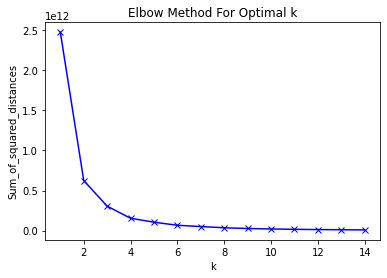

In [91]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### De acordo com o método Elbow, identificou-se que o número de clusters (k) adequado está em 2 e 4, no "cotovelo" do gráfico, conforme o método apresenta. O site utilizado para referência é o seguinte: https://medium.com/neuronio-br/aprendizado-n%C3%A3o-supervisionado-com-k-means-f4272dee98a0

### Average silhouette

#### A análise por Silhouette mede o quão bem um ponto se encaixa em um cluster. Neste método um gráfico é feito medindo quão perto os pontos de um cluster estão dos pontos de outro cluster mais próximo. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster.

In [92]:
# Plot Clustering

mms = MinMaxScaler()
mms.fit(df)
data_transformed = mms.transform(df)

Para n_clusters = 2 O score_silhouette médio é : 0.5930430568973901
Para n_clusters = 3 O score_silhouette médio é : 0.7095316380435915
Para n_clusters = 4 O score_silhouette médio é : 0.76034299288711
Para n_clusters = 5 O score_silhouette médio é : 0.7812726952043029


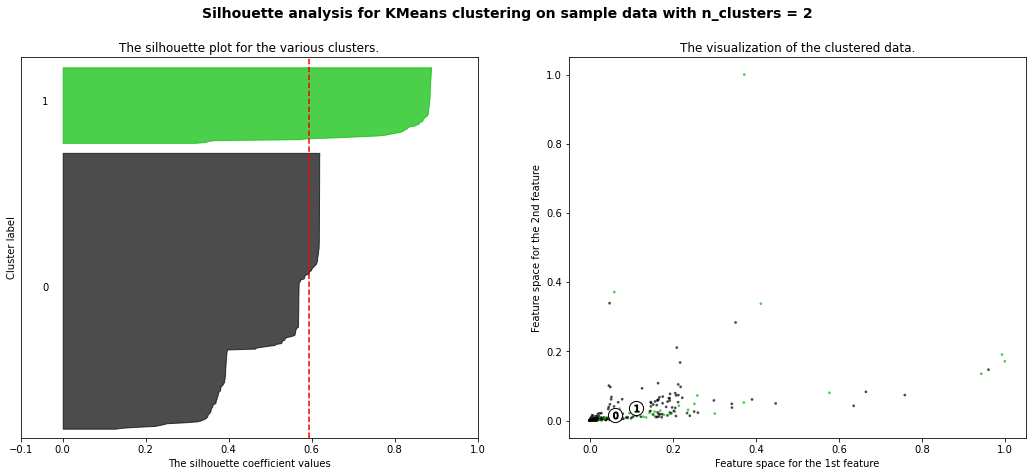

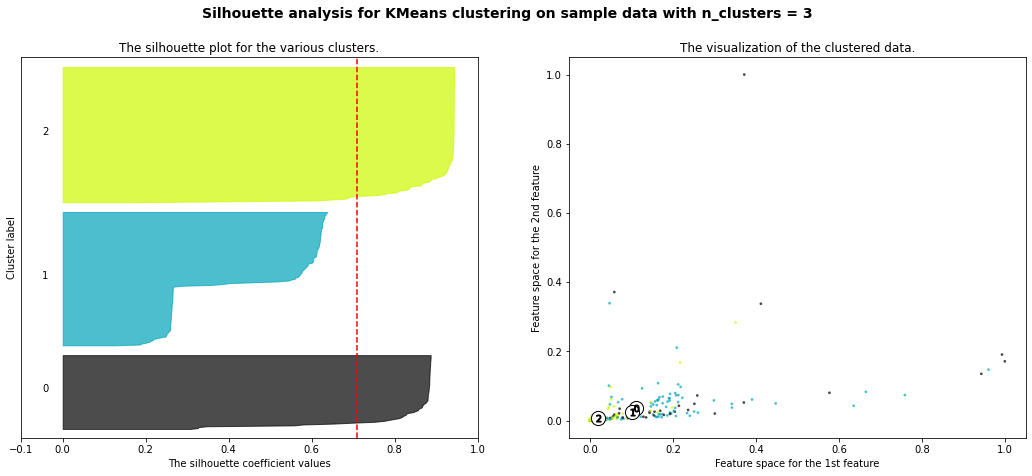

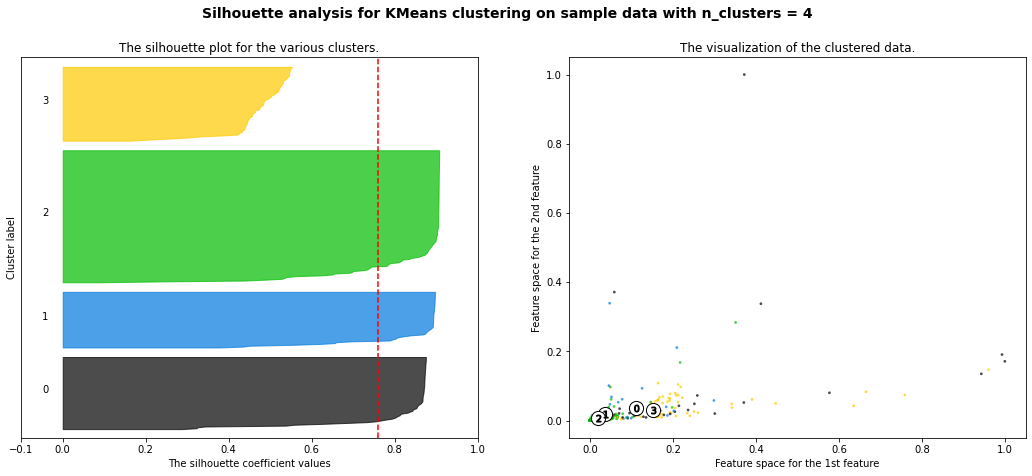

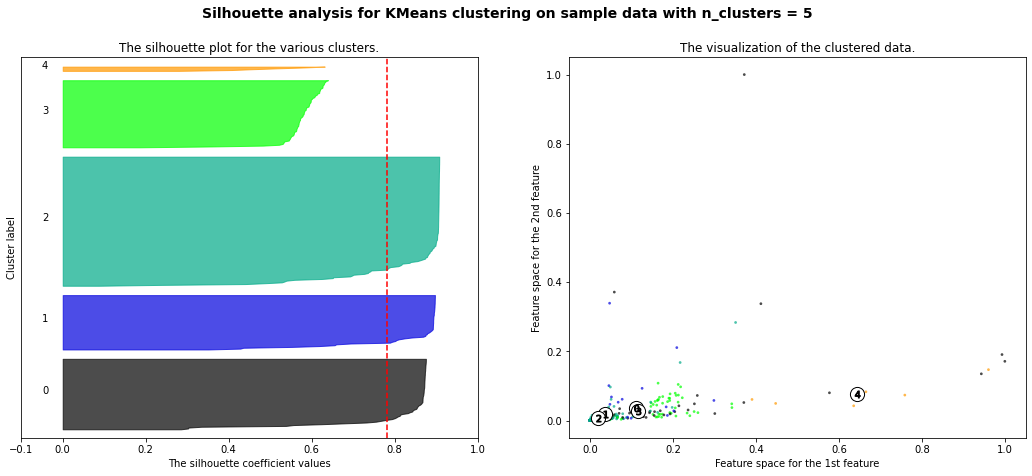

In [93]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.pyplot import cm

range_n_clusters = [2, 3, 4, 5]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data_transformed) + (n_clusters + 1) * 10])
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data_transformed)
# The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data_transformed, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette médio é :", silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_transformed, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(data_transformed[:, 0], data_transformed[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()



#### Fizemos uma análise comparativa entre 2 a 5 clusters. Quanto mais próximo a "average silhouette" é do valor 1 significa que os pontos de um determinado cluster estão mais longes de outro cluster vizinho, o que aumenta a performance do modelo, ou seja, dado uma nova observação x seria mais assertivo descobrir qual cluster/classe ela pertenceria.

#### Mas, devemos levar em conta o gráfico e como os clusters estão identificados. Um bom valor de k entrega um coeficiente de silhouette alto e no gráfico as expessuras são similares e devem passar a linha vermelha (o coeficiente score). 


#### Logo, observando o resultado, a melhor escolha é k=3. 



Coeficientes de silhueta (como esses valores são chamados) próximos a +1 indicam que a amostra está longe dos clusters vizinhos. Um valor de 0 indica que a amostra está muito perto do limite de decisão entre dois clusters vizinhos e valores negativos indicam que essas amostras podem ter sido atribuídas ao cluster errado.

Além disso, a partir da espessura do gráfico de silhueta, o tamanho do cluster pode ser visualizado. O gráfico de silhueta para o cluster 0 quando n_clustersé igual a 2, é maior em tamanho devido ao agrupamento dos 3 subgrupos em um grande cluster. No entanto, quando o n_clustersé igual a 4, todos os gráficos são mais ou menos de espessura semelhante e, portanto, são de tamanhos semelhantes, como também pode ser verificado no gráfico de dispersão rotulado à direita.

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

###Criando o modelo


In [94]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [95]:
y_predicted = kmeans.fit_predict(df)
y_predicted

array([1, 1, 1, 1, 1, 3, 4, 3, 1, 3, 3, 1, 2, 3, 1, 1, 1, 1, 1, 3, 3, 3,
       1, 2, 2, 3, 1, 1, 1, 1, 0, 1, 1, 1, 4, 1, 3, 1, 3, 1, 1, 0, 0, 3,
       3, 2, 2, 0, 0, 3, 0, 3, 3, 0, 3, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 1, 0, 3, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0,
       0, 3, 0, 3, 0, 0, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [96]:
df['cluster'] = y_predicted
df['channel_id'] = lb_make.inverse_transform(df['channel_id_code'])
df['video_id'] = lb_make1.inverse_transform(df1['video_id_code'])

df.head()

,likes,dislikes,views,comments_count,channel_id_code,is_commentable_bool,cluster,channel_id,video_id
0,3882,253,236509,49,0,1,1,UCG-fFAxQjZgJmn0w7Brj5xQ,NAtBWIcZh-M
1,3972,185,231872,52,0,1,1,UCG-fFAxQjZgJmn0w7Brj5xQ,iPm0zeYp0PU
2,4085,339,242798,75,0,1,1,UCG-fFAxQjZgJmn0w7Brj5xQ,WUOPyq-iAUw
3,4160,229,267444,84,0,1,1,UCG-fFAxQjZgJmn0w7Brj5xQ,AZOfUROgv3w
4,6392,130,188539,1110,0,1,1,UCG-fFAxQjZgJmn0w7Brj5xQ,kSW0fxmsBrg


In [97]:
df.head(50)

,likes,dislikes,views,comments_count,channel_id_code,is_commentable_bool,cluster,channel_id,video_id
0,3882,253,236509,49,0,1,1,UCG-fFAxQjZgJmn0w7Brj5xQ,NAtBWIcZh-M
1,3972,185,231872,52,0,1,1,UCG-fFAxQjZgJmn0w7Brj5xQ,iPm0zeYp0PU
2,4085,339,242798,75,0,1,1,UCG-fFAxQjZgJmn0w7Brj5xQ,WUOPyq-iAUw
3,4160,229,267444,84,0,1,1,UCG-fFAxQjZgJmn0w7Brj5xQ,AZOfUROgv3w
4,6392,130,188539,1110,0,1,1,UCG-fFAxQjZgJmn0w7Brj5xQ,kSW0fxmsBrg
5,3874,45,108069,645,0,1,3,UCG-fFAxQjZgJmn0w7Brj5xQ,lO2QfHL6Srw
6,14169,256,621618,2486,0,1,4,UCG-fFAxQjZgJmn0w7Brj5xQ,RtbagjEZxNs
7,4692,90,122153,957,0,1,3,UCG-fFAxQjZgJmn0w7Brj5xQ,kZ6qRd4TUtw
8,3662,73,151697,702,0,1,1,UCG-fFAxQjZgJmn0w7Brj5xQ,etwA2BOjeD0
10,1112,51,80835,219,0,1,3,UCG-fFAxQjZgJmn0w7Brj5xQ,-U9orROSkDo


In [98]:
# Traduzindo os clusters em palavras de performance

conditionlist = [
    (df['cluster'] == 0) ,
    (df['cluster'] == 1),
    (df['cluster'] == 2),
    (df['cluster'] == 3),
    (df['cluster'] == 4)]
choicelist = ['Tier 5','Tier 2', 'Tier 4', 'Tier 1', 'Tier 3']
df['performance_class'] = np.select(conditionlist, choicelist, default='Not Specified')

df.head()

,likes,dislikes,views,comments_count,channel_id_code,is_commentable_bool,cluster,channel_id,video_id,performance_class
0,3882,253,236509,49,0,1,1,UCG-fFAxQjZgJmn0w7Brj5xQ,NAtBWIcZh-M,Tier 2
1,3972,185,231872,52,0,1,1,UCG-fFAxQjZgJmn0w7Brj5xQ,iPm0zeYp0PU,Tier 2
2,4085,339,242798,75,0,1,1,UCG-fFAxQjZgJmn0w7Brj5xQ,WUOPyq-iAUw,Tier 2
3,4160,229,267444,84,0,1,1,UCG-fFAxQjZgJmn0w7Brj5xQ,AZOfUROgv3w,Tier 2
4,6392,130,188539,1110,0,1,1,UCG-fFAxQjZgJmn0w7Brj5xQ,kSW0fxmsBrg,Tier 2


In [99]:
#kmeans.cluster_centers_

O cluster_centers (verifica os centroides gerados dos atributos) gera um array com 5 instâncias e seus valores de atributos (df1[["likes", "dislikes", "views", "comments_count", "channel_id_code", "is_commentable_bool"]])


In [100]:
# Transformando as variáveis para números inteiros

import pandas as pd
# pd.to_numeric(df["views", "dislikes", "likes", "comments_count"])
df = df.astype({'views': 'int32', 'likes': 'int32', 'dislikes': 'int32','comments_count': 'int32'})

In [101]:
# Definindo dataframe só com cluster 0

df0 = df[df.cluster == 0].sort_values(by=['views'], ascending = False)

In [102]:
# Definindo dataframe só com cluster 1
df1 = df[df.cluster == 1].sort_values(by=['views'], ascending = False)

In [103]:
# Definindo dataframe só com cluster 2

df2 = df[df.cluster == 2].sort_values(by=['views'], ascending = False)

In [104]:
# Definindo dataframe só com cluster 2

df3 = df[df.cluster == 3].sort_values(by=['views'], ascending = False)

In [105]:
# Definindo dataframe só com cluster 2

df4 = df[df.cluster == 4].sort_values(by=['views'], ascending = False)

In [106]:
# Cluster 0
df0.describe().T

,count,mean,std,min,25%,50%,75%,max
likes,307.0,480.824104,876.644364,0.0,36.5,129.0,439.0,5622.0
dislikes,307.0,29.250814,109.511985,0.0,1.0,5.0,16.0,1293.0
views,307.0,6571.684039,8964.905802,0.0,699.5,2677.0,8795.5,45239.0
comments_count,307.0,46.622150,101.056093,0.0,0.0,6.0,43.5,712.0
channel_id_code,307.0,1.342020,0.664427,0.0,1.0,1.0,2.0,2.0
is_commentable_bool,307.0,0.762215,0.426422,0.0,1.0,1.0,1.0,1.0
cluster,307.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [107]:
#Cluster 1
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
likes,35.0,4925.400000,4276.837790,1089.0,3080.0,3594.0,4034.0,18668.0
dislikes,35.0,256.428571,181.854545,64.0,164.5,207.0,262.0,987.0
views,35.0,202097.942857,32562.180949,148558.0,179427.5,198637.0,229566.5,267444.0
comments_count,35.0,305.857143,667.250290,0.0,44.0,57.0,94.0,3647.0
channel_id_code,35.0,0.200000,0.531369,0.0,0.0,0.0,0.0,2.0
is_commentable_bool,35.0,0.914286,0.284029,0.0,1.0,1.0,1.0,1.0
cluster,35.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [108]:
# Cluster 2
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
likes,5.0,9810.8,5412.768164,3599.0,7296.0,8359.0,11869.0,17931.0
dislikes,5.0,224.8,167.556558,80.0,148.0,172.0,212.0,512.0
views,5.0,348707.0,42073.372482,289021.0,322804.0,366524.0,371792.0,393394.0
comments_count,5.0,1994.6,1022.623733,976.0,1458.0,1879.0,1979.0,3681.0
channel_id_code,5.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
is_commentable_bool,5.0,1.0,0.000000,1.0,1.0,1.0,1.0,1.0
cluster,5.0,2.0,0.000000,2.0,2.0,2.0,2.0,2.0


In [109]:
# Cluster 3
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
likes,39.0,3197.128205,2161.293304,0.0,1784.0,2974.0,3893.5,10778.0
dislikes,39.0,222.974359,580.298902,0.0,39.0,65.0,134.0,3483.0
views,39.0,89730.102564,27028.641375,49094.0,69578.0,81410.0,115611.0,133986.0
comments_count,39.0,471.846154,428.558817,0.0,16.5,508.0,721.5,1968.0
channel_id_code,39.0,0.923077,0.870106,0.0,0.0,1.0,2.0,2.0
is_commentable_bool,39.0,0.794872,0.409074,0.0,1.0,1.0,1.0,1.0
cluster,39.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0


In [110]:
# Cluster 4
df4.describe().T

,count,mean,std,min,25%,50%,75%,max
likes,2.0,13294.0,1237.436867,12419.0,12856.50,13294.0,13731.50,14169.0
dislikes,2.0,272.5,23.334524,256.0,264.25,272.5,280.75,289.0
views,2.0,555690.0,93236.271740,489762.0,522726.00,555690.0,588654.00,621618.0
comments_count,2.0,2378.5,152.027958,2271.0,2324.75,2378.5,2432.25,2486.0
channel_id_code,2.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0
is_commentable_bool,2.0,1.0,0.000000,1.0,1.00,1.0,1.00,1.0
cluster,2.0,4.0,0.000000,4.0,4.00,4.0,4.00,4.0


In [111]:
df_bq = df[['channel_id', 'video_id', 'performance_class', 'likes', 'dislikes', 'views', 'comments_count', 'is_commentable_bool', 'cluster']]
df_bq = df_bq.reset_index(drop=True).head(10)

#df_bq.loc[df_bq['video_id']=='XbTv4jWU6NY']

In [112]:
df_bq.dtypes

channel_id             object
video_id               object
performance_class      object
likes                   int32
dislikes                int32
views                   int32
comments_count          int32
is_commentable_bool     int64
cluster                 int32
dtype: object

In [113]:
lb_make = LabelEncoder()
# Transforming the classification variables from text to number
lista_channel_id_code = lb_make.fit_transform(df_bq["channel_id"])
lista_channel_id_code

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#Similar videos

In [114]:
import numpy
lista_dataframes=[]

for i in range(df_bq.shape[0]):
  video_id = df_bq.video_id[i]
  # compare_index = getIndexes(df_groups2, video_id)
  # position = compare_index[0][0]
  cluster = df_bq['cluster'][i]

  lista=[]
  lista_video_id_similar= []
  lista_video_id=[]
  
  for j in range(df_bq.shape[0]):
    video_id2 = df_bq.video_id[j]
    # compare_index2 = getIndexes(df_groups2, video_id2)
    # position2 = compare_index2[0][0]
    cluster2 = df_bq['cluster'][j]
    

    if cluster==cluster2:

      if i==j:
        np=numpy.NaN

      else:
        import numpy
        likes = df_bq['likes'][i]
        dislikes = df_bq['dislikes'][i]
        views = df_bq['views'][i]
        comments_count = df_bq['comments_count'][i]
        is_commentable_bool = df_bq['is_commentable_bool'][i]
        channel_id_code = lista_channel_id_code[i]

        x = numpy.array([likes, dislikes, views, comments_count, is_commentable_bool, channel_id_code])

        likes1 = df_bq['likes'][j]
        dislikes1 = df_bq['dislikes'][j]
        views1 = df_bq['views'][j]
        comments_count1 = df_bq['comments_count'][j]
        is_commentable_bool1 = df_bq['is_commentable_bool'][j]
        channel_id_code1 = lista_channel_id_code[j]

        y = numpy.array([likes1, dislikes1, views1, comments_count1, is_commentable_bool1, channel_id_code1])


        np = numpy.linalg.norm(x-y)


      lista.append(np)
      lista_video_id_similar.append(video_id2)
      lista_video_id.append(video_id)
      
  # print(lista)
  dict_video_distance = {'video_id_similar_performance': lista_video_id_similar,
                        'distance_performance': lista,
                        'video_id': lista_video_id}

  df_distance = pd.DataFrame(dict_video_distance)
  df_distance

  df_distance_five_min = df_distance.nsmallest(5, 'distance_performance')
  lista_dataframes.append(df_distance_five_min)
  concat=pd.concat(lista_dataframes)

print(concat)

  video_id_similar_performance  distance_performance     video_id
1                  iPm0zeYp0PU           4638.372775  NAtBWIcZh-M
2                  WUOPyq-iAUw           6292.916812  NAtBWIcZh-M
3                  AZOfUROgv3w          30936.278218  NAtBWIcZh-M
4                  kSW0fxmsBrg          48047.495772  NAtBWIcZh-M
5                  etwA2BOjeD0          84814.990143  NAtBWIcZh-M
0                  NAtBWIcZh-M           4638.372775  iPm0zeYp0PU
2                  WUOPyq-iAUw          10927.693718  iPm0zeYp0PU
3                  AZOfUROgv3w          35572.538397  iPm0zeYp0PU
4                  kSW0fxmsBrg          43413.450427  iPm0zeYp0PU
5                  etwA2BOjeD0          80178.312336  iPm0zeYp0PU
0                  NAtBWIcZh-M           6292.916812  WUOPyq-iAUw
1                  iPm0zeYp0PU          10927.693718  WUOPyq-iAUw
3                  AZOfUROgv3w          24646.361232  WUOPyq-iAUw
4                  kSW0fxmsBrg          54318.286387  WUOPyq-iAUw
5         

In [115]:
df_merge = pd.merge(concat, df_bq, how = 'inner', on = 'video_id')
df_merge.head()

,video_id_similar_performance,distance_performance,video_id,channel_id,performance_class,likes,dislikes,views,comments_count,is_commentable_bool,cluster
0,iPm0zeYp0PU,4638.372775,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1
1,WUOPyq-iAUw,6292.916812,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1
2,AZOfUROgv3w,30936.278218,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1
3,kSW0fxmsBrg,48047.495772,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1
4,etwA2BOjeD0,84814.990143,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1


##Pegando dados do BQ com tittle do video_id

In [116]:
import os
os.environ["GOOGLE_APPLICATION_CREDENIALS"]="key_vibra.json"

In [76]:
#Pegando os dados do BigQuery com nomes de vídeos

import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage

# Explicitly create a credentials object. This allows you to use the same
# credentials for both the BigQuery and BigQuery Storage clients, avoiding
# unnecessary API calls to fetch duplicate authentication tokens.
credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

# Make clients.
bqclient = bigquery.Client(credentials=credentials, project='vibra-022021')
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

# Download a table.
table = bigquery.TableReference.from_string(
    "vibra-022021.vibraBQ.vbr_ytb_pprz_videos"
)
rows = bqclient.list_rows(
    table,
    selected_fields=[
        bigquery.SchemaField("channel_id", "STRING"),
        bigquery.SchemaField("video_id", "STRING"),
        bigquery.SchemaField("title", "STRING"),
        
    ],
)
dataframe_papparazo_tittle = rows.to_dataframe()

In [117]:
dataframe_papparazo_tittle.drop_duplicates(subset='video_id', keep='first',  ignore_index=True)

,channel_id,video_id,title
0,UCG-fFAxQjZgJmn0w7Brj5xQ,K_ox0Mns-fk,[AO VIVO] BRASIL URGENTE COM DATENA – 28/04/2021
1,UCG-fFAxQjZgJmn0w7Brj5xQ,wsbVSUaF9Jg,[AO VIVO] BRASIL URGENTE COM DATENA – 29/04/2021
2,UCG-fFAxQjZgJmn0w7Brj5xQ,M_CX6_DFW-0,"EM CARTA, MÃE DE HENRY ACUSA JAIRINHO | BRASIL..."
3,UCG-fFAxQjZgJmn0w7Brj5xQ,lO2QfHL6Srw,PAI DE HENRY RELATA FRIEZA DE JAIRINHO | BRASI...
4,UCG-fFAxQjZgJmn0w7Brj5xQ,sVNjZjN9LUQ,CASO HENRY: BABÁ NARROU TORTURA À MÃE | BRASIL...
...,...,...,...
381,UCWijW6tW0iI5ghsAbWDFtTg,dLjENDLHh6Y,"Reinaldo Azevedo: Até demorou, mas Bolsonaro d..."
382,UCWijW6tW0iI5ghsAbWDFtTg,kD8h7RuzTgo,&quot;Jurei proteger a vida da população&quot;...
383,UCWijW6tW0iI5ghsAbWDFtTg,xl5RBotuy2Y,&quot;Não queriam fazer uma campanha instituci...
384,UCWijW6tW0iI5ghsAbWDFtTg,dGtvfzcjFek,&quot;Doença infecciosa por vírus é combatida ...


In [119]:
df_merge.head()

,video_id_similar_performance,distance_performance,video_id,channel_id,performance_class,likes,dislikes,views,comments_count,is_commentable_bool,cluster
0,iPm0zeYp0PU,4638.372775,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1
1,WUOPyq-iAUw,6292.916812,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1
2,AZOfUROgv3w,30936.278218,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1
3,kSW0fxmsBrg,48047.495772,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1
4,etwA2BOjeD0,84814.990143,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1


In [120]:
df_filter = dataframe_papparazo_tittle[["video_id", "title"]]
df_filter.head()

,video_id,title
0,K_ox0Mns-fk,[AO VIVO] BRASIL URGENTE COM DATENA – 28/04/2021
1,wsbVSUaF9Jg,[AO VIVO] BRASIL URGENTE COM DATENA – 29/04/2021
2,M_CX6_DFW-0,"EM CARTA, MÃE DE HENRY ACUSA JAIRINHO | BRASIL..."
3,lO2QfHL6Srw,PAI DE HENRY RELATA FRIEZA DE JAIRINHO | BRASI...
4,sVNjZjN9LUQ,CASO HENRY: BABÁ NARROU TORTURA À MÃE | BRASIL...


In [121]:
merge_video_tittle = pd.merge(df_merge, df_filter, how = 'inner', on = 'video_id')
merge_video_tittle.head(10)

,video_id_similar_performance,distance_performance,video_id,channel_id,performance_class,likes,dislikes,views,comments_count,is_commentable_bool,cluster,title
0,iPm0zeYp0PU,4638.372775,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1,BRASIL URGENTE COM DATENA – 13/04/2021 - PROGR...
1,WUOPyq-iAUw,6292.916812,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1,BRASIL URGENTE COM DATENA – 13/04/2021 - PROGR...
2,AZOfUROgv3w,30936.278218,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1,BRASIL URGENTE COM DATENA – 13/04/2021 - PROGR...
3,kSW0fxmsBrg,48047.495772,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1,BRASIL URGENTE COM DATENA – 13/04/2021 - PROGR...
4,etwA2BOjeD0,84814.990143,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1,BRASIL URGENTE COM DATENA – 13/04/2021 - PROGR...
5,NAtBWIcZh-M,4638.372775,iPm0zeYp0PU,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3972,185,231872,52,1,1,BRASIL URGENTE COM DATENA – 08/04/2021 - PROGR...
6,WUOPyq-iAUw,10927.693718,iPm0zeYp0PU,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3972,185,231872,52,1,1,BRASIL URGENTE COM DATENA – 08/04/2021 - PROGR...
7,AZOfUROgv3w,35572.538397,iPm0zeYp0PU,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3972,185,231872,52,1,1,BRASIL URGENTE COM DATENA – 08/04/2021 - PROGR...
8,kSW0fxmsBrg,43413.450427,iPm0zeYp0PU,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3972,185,231872,52,1,1,BRASIL URGENTE COM DATENA – 08/04/2021 - PROGR...
9,etwA2BOjeD0,80178.312336,iPm0zeYp0PU,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3972,185,231872,52,1,1,BRASIL URGENTE COM DATENA – 08/04/2021 - PROGR...


In [122]:
merge_video_tittle.rename(columns={'title':'title_video_id_performance'}, inplace = True)
merge_video_tittle.drop_duplicates(subset=['video_id_similar_performance', 'video_id', 'distance_performance', 'cluster'], keep='first',  ignore_index=True)

,video_id_similar_performance,distance_performance,video_id,channel_id,performance_class,likes,dislikes,views,comments_count,is_commentable_bool,cluster,title_video_id_performance
0,iPm0zeYp0PU,4638.372775,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1,BRASIL URGENTE COM DATENA – 13/04/2021 - PROGR...
1,WUOPyq-iAUw,6292.916812,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1,BRASIL URGENTE COM DATENA – 13/04/2021 - PROGR...
2,AZOfUROgv3w,30936.278218,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1,BRASIL URGENTE COM DATENA – 13/04/2021 - PROGR...
3,kSW0fxmsBrg,48047.495772,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1,BRASIL URGENTE COM DATENA – 13/04/2021 - PROGR...
4,etwA2BOjeD0,84814.990143,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1,BRASIL URGENTE COM DATENA – 13/04/2021 - PROGR...
5,NAtBWIcZh-M,4638.372775,iPm0zeYp0PU,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3972,185,231872,52,1,1,BRASIL URGENTE COM DATENA – 08/04/2021 - PROGR...
6,WUOPyq-iAUw,10927.693718,iPm0zeYp0PU,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3972,185,231872,52,1,1,BRASIL URGENTE COM DATENA – 08/04/2021 - PROGR...
7,AZOfUROgv3w,35572.538397,iPm0zeYp0PU,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3972,185,231872,52,1,1,BRASIL URGENTE COM DATENA – 08/04/2021 - PROGR...
8,kSW0fxmsBrg,43413.450427,iPm0zeYp0PU,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3972,185,231872,52,1,1,BRASIL URGENTE COM DATENA – 08/04/2021 - PROGR...
9,etwA2BOjeD0,80178.312336,iPm0zeYp0PU,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3972,185,231872,52,1,1,BRASIL URGENTE COM DATENA – 08/04/2021 - PROGR...


In [123]:
df_filter['video_id_similar_performance']=df_filter['video_id']
df_filter2=df_filter[['title', 'video_id_similar_performance']]
df_filter2

,title,video_id_similar_performance
0,[AO VIVO] BRASIL URGENTE COM DATENA – 28/04/2021,K_ox0Mns-fk
1,[AO VIVO] BRASIL URGENTE COM DATENA – 29/04/2021,wsbVSUaF9Jg
2,"EM CARTA, MÃE DE HENRY ACUSA JAIRINHO | BRASIL...",M_CX6_DFW-0
3,PAI DE HENRY RELATA FRIEZA DE JAIRINHO | BRASI...,lO2QfHL6Srw
4,CASO HENRY: BABÁ NARROU TORTURA À MÃE | BRASIL...,sVNjZjN9LUQ
...,...,...
718,Álvaro Furtado sobre atraso da 2ª dose: &quot;...,DEoZi3xZCdo
719,Álvaro Furtado sobre atraso da 2ª dose: &quot;...,DEoZi3xZCdo
720,Álvaro Furtado sobre atraso da 2ª dose: &quot;...,DEoZi3xZCdo
721,Álvaro Furtado sobre atraso da 2ª dose: &quot;...,DEoZi3xZCdo


In [124]:
df_filter2.drop_duplicates(subset='video_id_similar_performance', keep='first',  ignore_index=True)

,title,video_id_similar_performance
0,[AO VIVO] BRASIL URGENTE COM DATENA – 28/04/2021,K_ox0Mns-fk
1,[AO VIVO] BRASIL URGENTE COM DATENA – 29/04/2021,wsbVSUaF9Jg
2,"EM CARTA, MÃE DE HENRY ACUSA JAIRINHO | BRASIL...",M_CX6_DFW-0
3,PAI DE HENRY RELATA FRIEZA DE JAIRINHO | BRASI...,lO2QfHL6Srw
4,CASO HENRY: BABÁ NARROU TORTURA À MÃE | BRASIL...,sVNjZjN9LUQ
...,...,...
381,"Reinaldo Azevedo: Até demorou, mas Bolsonaro d...",dLjENDLHh6Y
382,&quot;Jurei proteger a vida da população&quot;...,kD8h7RuzTgo
383,&quot;Não queriam fazer uma campanha instituci...,xl5RBotuy2Y
384,&quot;Doença infecciosa por vírus é combatida ...,dGtvfzcjFek


In [132]:
merge_video_tittle2 = pd.merge(merge_video_tittle, df_filter2, how = 'inner', on = 'video_id_similar_performance')
merge_video_tittle2.shape

(40, 13)

In [130]:
merge_video_tittle2.rename(columns={'title': 'title_video_id_similar_performance'}, inplace = True)
#merge_video_tittle2.drop_duplicates(subset=['video_id_similar_performance', 'video_id', 'distance_performance', 'cluster'], keep='first',  ignore_index=True, inplace=True)

In [131]:
merge_video_tittle2

,video_id_similar_performance,distance_performance,video_id,channel_id,performance_class,likes,dislikes,views,comments_count,is_commentable_bool,cluster,title_video_id_performance,title_video_id_similar_performance
0,iPm0zeYp0PU,4638.372775,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1,BRASIL URGENTE COM DATENA – 13/04/2021 - PROGR...,BRASIL URGENTE COM DATENA – 08/04/2021 - PROGR...
1,iPm0zeYp0PU,10927.693718,WUOPyq-iAUw,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,4085,339,242798,75,1,1,BRASIL URGENTE COM DATENA – 12/04/2021 - PROGR...,BRASIL URGENTE COM DATENA – 08/04/2021 - PROGR...
2,iPm0zeYp0PU,35572.538397,AZOfUROgv3w,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,4160,229,267444,84,1,1,BRASIL URGENTE COM DATENA – 09/04/2021 - PROGR...,BRASIL URGENTE COM DATENA – 08/04/2021 - PROGR...
3,iPm0zeYp0PU,43413.450427,kSW0fxmsBrg,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,6392,130,188539,1110,1,1,PERITA EXPLICA AS 23 LESÕES DE HENRY BOREL | B...,BRASIL URGENTE COM DATENA – 08/04/2021 - PROGR...
4,iPm0zeYp0PU,80178.312336,etwA2BOjeD0,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3662,73,151697,702,1,1,CASO HENRY: BABÁ PRESTA DEPOIMENTO À POLÍCIA |...,BRASIL URGENTE COM DATENA – 08/04/2021 - PROGR...
5,WUOPyq-iAUw,6292.916812,NAtBWIcZh-M,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3882,253,236509,49,1,1,BRASIL URGENTE COM DATENA – 13/04/2021 - PROGR...,BRASIL URGENTE COM DATENA – 12/04/2021 - PROGR...
6,WUOPyq-iAUw,10927.693718,iPm0zeYp0PU,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3972,185,231872,52,1,1,BRASIL URGENTE COM DATENA – 08/04/2021 - PROGR...,BRASIL URGENTE COM DATENA – 12/04/2021 - PROGR...
7,WUOPyq-iAUw,24646.361232,AZOfUROgv3w,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,4160,229,267444,84,1,1,BRASIL URGENTE COM DATENA – 09/04/2021 - PROGR...,BRASIL URGENTE COM DATENA – 12/04/2021 - PROGR...
8,WUOPyq-iAUw,54318.286387,kSW0fxmsBrg,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,6392,130,188539,1110,1,1,PERITA EXPLICA AS 23 LESÕES DE HENRY BOREL | B...,BRASIL URGENTE COM DATENA – 12/04/2021 - PROGR...
9,WUOPyq-iAUw,91104.527961,etwA2BOjeD0,UCG-fFAxQjZgJmn0w7Brj5xQ,Tier 2,3662,73,151697,702,1,1,CASO HENRY: BABÁ PRESTA DEPOIMENTO À POLÍCIA |...,BRASIL URGENTE COM DATENA – 12/04/2021 - PROGR...


In [128]:
merge_video_tittle2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   video_id_similar_performance        36 non-null     object 
 1   distance_performance                36 non-null     float64
 2   video_id                            36 non-null     object 
 3   channel_id                          36 non-null     object 
 4   performance_class                   36 non-null     object 
 5   likes                               36 non-null     int32  
 6   dislikes                            36 non-null     int32  
 7   views                               36 non-null     int32  
 8   comments_count                      36 non-null     int32  
 9   is_commentable_bool                 36 non-null     int64  
 10  cluster                             36 non-null     int32  
 11  title_video_id_performance          36 non-null

##Inserindo dados no BigQuery

In [129]:
import datetime
from datetime import date
from google.cloud import bigquery
import pandas
import pytz

import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage

# Explicitly create a credentials object. This allows you to use the same
# credentials for both the BigQuery and BigQuery Storage clients, avoiding
# unnecessary API calls to fetch duplicate authentication tokens.

# Make clients.

table_id = "vibra-022021.vibraBQ.vbr_csgr_performance" 
job = bqclient.load_table_from_dataframe(merge_video_tittle2, table_id)
job.result()